In [1]:

# from google.colab import drive
# import os

# # Mount Google Drive
# drive.mount('/content/drive')

# # Setup Kaggle credentials
# kaggle_json_path = '/content/drive/MyDrive/Kaggle/kaggle.json'

# # Buat folder .kaggle di root
# os.makedirs('/root/.kaggle', exist_ok=True)

# # Copy kaggle.json ke folder yang tepat
# !cp "{kaggle_json_path}" /root/.kaggle/kaggle.json

# # Set permissions
# !chmod 600 /root/.kaggle/kaggle.json


# print("✓ Google Drive mounted")
# print("✓ Kaggle credentials configured")

In [1]:
!pip install -q kaggle
!pip install -q torchmetrics
!pip install -q timm

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import timm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, auc, confusion_matrix,
    matthews_corrcoef
)
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.6 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✓ All libraries imported successfully


In [3]:
# # Download dataset
# !kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

# # Unzip dataset
# !unzip -q melanoma-skin-cancer-dataset-of-10000-images.zip -d melanoma_dataset

# print("✓ Dataset downloaded and extracted")

# # Cek struktur folder
# !ls -la melanoma_dataset/

In [3]:
# Definisi transformasi untuk training (dengan augmentasi)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Definisi transformasi untuk testing (tanpa augmentasi)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print("✓ Data transformations defined")

✓ Data transformations defined


In [4]:
# train_data_path = 'melanoma_dataset/melanoma_cancer_dataset/train'  # Sesuaikan dengan struktur folder
# test_data_path = 'melanoma_dataset/melanoma_cancer_dataset/test'    # Sesuaikan dengan struktur folder

base_path = '/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset'

train_data_path = os.path.join(base_path, 'train')
test_data_path = os.path.join(base_path, 'test')

# Load datasets
train_dataset = ImageFolder(root=train_data_path, transform=train_transforms)
test_dataset = ImageFolder(root=test_data_path, transform=test_transforms)

print(f"✓ Training samples: {len(train_dataset)}")
print(f"✓ Testing samples: {len(test_dataset)}")
print(f"✓ Classes: {train_dataset.classes}")
print(f"✓ Class to index mapping: {train_dataset.class_to_idx}")

✓ Training samples: 9605
✓ Testing samples: 1000
✓ Classes: ['benign', 'malignant']
✓ Class to index mapping: {'benign': 0, 'malignant': 1}


In [5]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Test batches: {len(test_loader)}")

✓ Train batches: 301
✓ Test batches: 32


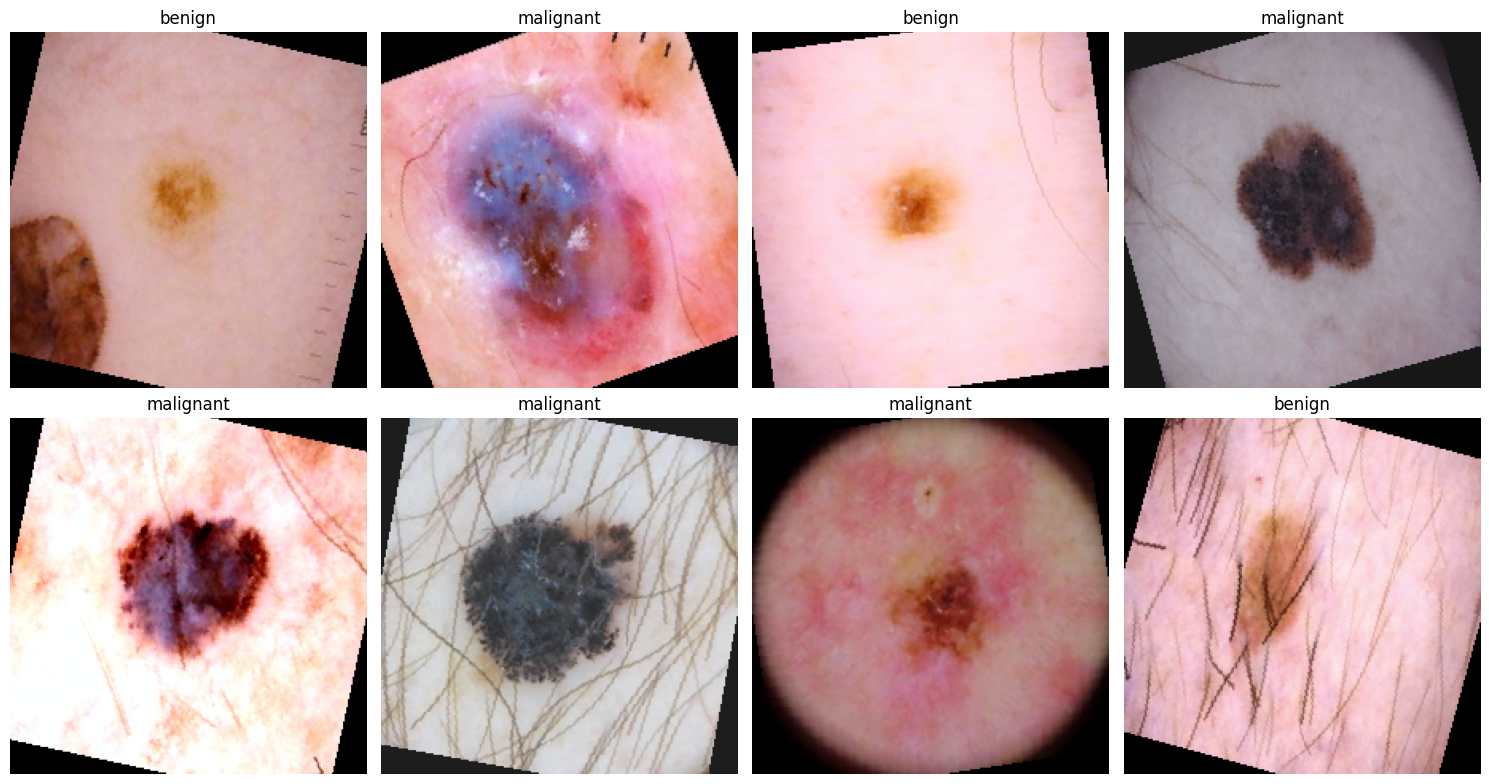

In [6]:
def imshow(img, title):
    """Denormalisasi dan tampilkan gambar"""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Ambil batch pertama
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Tampilkan 8 gambar pertama
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for idx in range(8):
    ax = axes[idx // 4, idx % 4]
    plt.sca(ax)
    class_name = train_dataset.classes[labels[idx]]
    imshow(images[idx], f'{class_name}')
plt.tight_layout()
plt.show()

In [7]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")

✓ Using device: cuda


In [10]:
# ===================================================================
# CELL 8: Define EfficientNet-B0 Model
# ===================================================================
import torch
import torch.nn as nn
from torchvision import models

class MelanomaEfficientNetB0(nn.Module):
    def __init__(self, num_classes=2, pretrained=False):
        super(MelanomaEfficientNetB0, self).__init__()

        # Load pretrained EfficientNet-B0
        self.efficientnet = models.efficientnet_b0(pretrained=pretrained)

        # Ambil jumlah fitur dari classifier bawaan
        num_features = self.efficientnet.classifier[1].in_features

        # Modifikasi classifier sesuai struktur paper
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

efficientnet_model = MelanomaEfficientNetB0(num_classes=2, pretrained=False)
efficientnet_model.load_state_dict(torch.load('/kaggle/input/efficientnetb-0/tensorflow2/default/1/best_efficientnetb0_melanoma.pth', map_location=device))
efficientnet_model = efficientnet_model.to(device)
efficientnet_model.eval()
print("✓ EfficientNetB-0 model loaded")

# # Setup device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"✓ Using device: {device}")

# # Inisialisasi model
# model = MelanomaEfficientNetB0(num_classes=2, pretrained=True)
# model = model.to(device)

# print("✓ EfficientNet-B0 model initialized")
# print(f"✓ Total parameters: {sum(p.numel() for p in model.parameters()):,}")

✓ EfficientNetB-0 model loaded


In [11]:
# ===================================================================
# CELL 8: Define ResNet-18 Model
# ===================================================================
class MelanomaResNet18(nn.Module):
    def __init__(self, num_classes=2, pretrained=False):
        super(MelanomaResNet18, self).__init__()

        # Load pretrained ResNet-18
        self.resnet18 = models.resnet18(pretrained=pretrained)

        # Modifikasi classifier sesuai paper
        # Paper menyebutkan FC dengan 4096 dan 10000 neurons
        num_features = self.resnet18.fc.in_features

        self.resnet18.fc = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, num_classes)
        )

    def forward(self, x):
        return self.resnet18(x)
        
resnet_model = MelanomaResNet18(num_classes=2, pretrained=False)
resnet_model.load_state_dict(torch.load('/kaggle/input/resnet-18/pytorch/default/1/best_resnet18_melanoma.pth', map_location=device))
resnet_model = resnet_model.to(device)
resnet_model.eval()
print("✓ ResNet-18 model loaded")

# # Setup device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"✓ Using device: {device}")

# # Inisialisasi model
# model = MelanomaResNet18(num_classes=2, pretrained=True)
# model = model.to(device)

# print("✓ ResNet-18 model initialized")
# print(f"✓ Total parameters: {sum(p.numel() for p in model.parameters()):,}")

✓ ResNet-18 model loaded


In [12]:


# ===================================================================
# Ensemble Class
# ===================================================================
class EnsembleModel(nn.Module):
    def __init__(self, models_list, voting='soft', weights=None):
        """
        Ensemble model dengan soft atau hard voting
        
        Args:
            models_list: List of trained models
            voting: 'soft' atau 'hard'
            weights: List of weights untuk setiap model (opsional, default equal weights)
        """
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models_list)
        self.voting = voting
        
        # Set weights untuk soft voting
        if weights is None:
            self.weights = [1.0 / len(models_list)] * len(models_list)
        else:
            assert len(weights) == len(models_list), "Jumlah weights harus sama dengan jumlah models"
            total = sum(weights)
            self.weights = [w / total for w in weights]  # Normalize weights
        
        # Set semua model ke eval mode
        for model in self.models:
            model.eval()
    
    def forward(self, x):
        """
        Forward pass dengan ensemble voting
        """
        if self.voting == 'soft':
            return self.soft_voting(x)
        elif self.voting == 'hard':
            return self.hard_voting(x)
        else:
            raise ValueError("Voting harus 'soft' atau 'hard'")
    
    def soft_voting(self, x):
        """
        Soft voting: rata-rata weighted dari probabilitas
        """
        outputs = []
        
        with torch.no_grad():
            for model, weight in zip(self.models, self.weights):
                output = model(x)
                # Konversi ke probabilitas dengan softmax
                prob = F.softmax(output, dim=1)
                # Apply weight
                outputs.append(prob * weight)
        
        # Rata-rata weighted dari semua probabilitas
        ensemble_prob = torch.stack(outputs).sum(dim=0)
        
        return ensemble_prob
    
    def hard_voting(self, x):
        """
        Hard voting: majority vote dari prediksi kelas
        """
        predictions = []
        
        with torch.no_grad():
            for model in self.models:
                output = model(x)
                # Ambil kelas dengan probabilitas tertinggi
                pred = torch.argmax(output, dim=1)
                predictions.append(pred)
        
        # Stack semua prediksi
        predictions = torch.stack(predictions)  # Shape: (num_models, batch_size)
        
        # Majority voting untuk setiap sample
        # Mode (nilai yang paling sering muncul)
        ensemble_pred, _ = torch.mode(predictions, dim=0)
        
        # Konversi ke format probabilitas untuk konsistensi
        # (one-hot encoding)
        batch_size = x.size(0)
        num_classes = 2
        ensemble_prob = torch.zeros(batch_size, num_classes, device=x.device)
        ensemble_prob[torch.arange(batch_size), ensemble_pred] = 1.0
        
        return ensemble_prob
    
    def predict(self, x):
        """
        Prediksi kelas untuk input
        """
        output = self.forward(x)
        return torch.argmax(output, dim=1)
    
    def predict_proba(self, x):
        """
        Prediksi probabilitas untuk setiap kelas
        """
        return self.forward(x)

# ===================================================================
# Inisialisasi Ensemble Models
# ===================================================================

models_list = [resnet_model, efficientnet_model]

# Soft Voting Ensemble (equal weights)
ensemble_soft = EnsembleModel(models_list, voting='soft')
ensemble_soft = ensemble_soft.to(device)
print("✓ Soft Voting Ensemble initialized (equal weights)")

# Soft Voting Ensemble (custom weights - contoh: ResNet 60%, EfficientNet 40%)
ensemble_soft_weighted = EnsembleModel(models_list, voting='soft', weights=[0.6, 0.4])
ensemble_soft_weighted = ensemble_soft_weighted.to(device)
print("✓ Soft Voting Ensemble initialized (weighted: 60-40)")

# Hard Voting Ensemble
ensemble_hard = EnsembleModel(models_list, voting='hard')
ensemble_hard = ensemble_hard.to(device)
print("✓ Hard Voting Ensemble initialized")


✓ Soft Voting Ensemble initialized (equal weights)
✓ Soft Voting Ensemble initialized (weighted: 60-40)
✓ Hard Voting Ensemble initialized


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import numpy as np

In [14]:
class EnsembleModel(nn.Module):
    def __init__(self, models_list, voting='soft', weights=None):
        """
        Ensemble model dengan soft atau hard voting
        
        Args:
            models_list: List of trained models
            voting: 'soft' atau 'hard'
            weights: List of weights untuk setiap model (opsional, default equal weights)
        """
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models_list)
        self.voting = voting
        
        # Set weights untuk soft voting
        if weights is None:
            self.weights = [1.0 / len(models_list)] * len(models_list)
        else:
            assert len(weights) == len(models_list), "Jumlah weights harus sama dengan jumlah models"
            total = sum(weights)
            self.weights = [w / total for w in weights]  # Normalize weights
        
        # Set semua model ke eval mode
        for model in self.models:
            model.eval()
    
    def forward(self, x):
        """
        Forward pass dengan ensemble voting
        """
        if self.voting == 'soft':
            return self.soft_voting(x)
        elif self.voting == 'hard':
            return self.hard_voting(x)
        else:
            raise ValueError("Voting harus 'soft' atau 'hard'")
    
    def soft_voting(self, x):
        """
        Soft voting: rata-rata weighted dari probabilitas
        """
        outputs = []
        
        with torch.no_grad():
            for model, weight in zip(self.models, self.weights):
                output = model(x)
                # Konversi ke probabilitas dengan softmax
                prob = F.softmax(output, dim=1)
                # Apply weight
                outputs.append(prob * weight)
        
        # Rata-rata weighted dari semua probabilitas
        ensemble_prob = torch.stack(outputs).sum(dim=0)
        
        return ensemble_prob
    
    def hard_voting(self, x):
        """
        Hard voting: majority vote dari prediksi kelas
        """
        predictions = []
        
        with torch.no_grad():
            for model in self.models:
                output = model(x)
                # Ambil kelas dengan probabilitas tertinggi
                pred = torch.argmax(output, dim=1)
                predictions.append(pred)
        
        # Stack semua prediksi
        predictions = torch.stack(predictions)  # Shape: (num_models, batch_size)
        
        # Majority voting untuk setiap sample
        # Mode (nilai yang paling sering muncul)
        ensemble_pred, _ = torch.mode(predictions, dim=0)
        
        # Konversi ke format probabilitas untuk konsistensi
        # (one-hot encoding)
        batch_size = x.size(0)
        num_classes = 2
        ensemble_prob = torch.zeros(batch_size, num_classes, device=x.device)
        ensemble_prob[torch.arange(batch_size), ensemble_pred] = 1.0
        
        return ensemble_prob
    
    def predict(self, x):
        """
        Prediksi kelas untuk input
        """
        output = self.forward(x)
        return torch.argmax(output, dim=1)
    
    def predict_proba(self, x):
        """
        Prediksi probabilitas untuk setiap kelas
        """
        return self.forward(x)

In [16]:
import pandas as pd

def evaluate_model(model, dataloader, model_name="Model"):
    model.eval()
    all_preds = []
    all_labels = []
    
    print(f"\n{'='*60}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*60}")
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Get predictions
            outputs = model(images)
            
            # Untuk ensemble, outputs sudah berupa probabilitas
            # Untuk individual model, perlu softmax
            if isinstance(model, EnsembleModel):
                probs = outputs
            else:
                probs = F.softmax(outputs, dim=1)
            
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    
    print(f"\nResults:")
    print(f"  Accuracy:  {accuracy*100:.2f}%")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# ===================================================================
# RUN EVALUATION
# ===================================================================
print("\n" + "="*60)
print("STARTING EVALUATION")
print("="*60)

# Evaluate individual models
resnet_results = evaluate_model(resnet_model, test_loader, "ResNet-18")
efficientnet_results = evaluate_model(efficientnet_model, test_loader, "EfficientNet-B0")

# Evaluate ensemble models
soft_results = evaluate_model(ensemble_soft, test_loader, "Soft Voting (Equal)")
soft_weighted_results = evaluate_model(ensemble_soft_weighted, test_loader, "Soft Voting (60-40)")
hard_results = evaluate_model(ensemble_hard, test_loader, "Hard Voting")

# ===================================================================
# COMPARISON TABLE
# ===================================================================
results_df = pd.DataFrame({
    'Model': [
        'ResNet-18', 
        'EfficientNet-B0', 
        'Soft Voting (Equal)', 
        'Soft Voting (60-40)', 
        'Hard Voting'
    ],
    'Accuracy (%)': [
        resnet_results['accuracy']*100,
        efficientnet_results['accuracy']*100,
        soft_results['accuracy']*100,
        soft_weighted_results['accuracy']*100,
        hard_results['accuracy']*100
    ],
    'Precision': [
        resnet_results['precision'],
        efficientnet_results['precision'],
        soft_results['precision'],
        soft_weighted_results['precision'],
        hard_results['precision']
    ],
    'Recall': [
        resnet_results['recall'],
        efficientnet_results['recall'],
        soft_results['recall'],
        soft_weighted_results['recall'],
        hard_results['recall']
    ],
    'F1-Score': [
        resnet_results['f1'],
        efficientnet_results['f1'],
        soft_results['f1'],
        soft_weighted_results['f1'],
        hard_results['f1']
    ]
})

print("\n" + "="*80)
print("FINAL COMPARISON - ALL MODELS")
print("="*80)
print(results_df.to_string(index=False))

# Find best model
best_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.iloc[best_idx]['Model']
best_f1 = results_df.iloc[best_idx]['F1-Score']


print(f"\n{'='*80}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Accuracy: {results_df.iloc[best_idx]['Accuracy (%)']:.2f}%")
print(f"{'='*80}")


STARTING EVALUATION

Evaluating: ResNet-18

Results:
  Accuracy:  92.50%
  Precision: 0.9650
  Recall:    0.8820
  F1-Score:  0.9216

Confusion Matrix:
[[484  16]
 [ 59 441]]

Evaluating: EfficientNet-B0

Results:
  Accuracy:  92.90%
  Precision: 0.9299
  Recall:    0.9280
  F1-Score:  0.9289

Confusion Matrix:
[[465  35]
 [ 36 464]]

Evaluating: Soft Voting (Equal)

Results:
  Accuracy:  92.40%
  Precision: 0.9417
  Recall:    0.9040
  F1-Score:  0.9224

Confusion Matrix:
[[472  28]
 [ 48 452]]

Evaluating: Soft Voting (60-40)

Results:
  Accuracy:  92.70%
  Precision: 0.9572
  Recall:    0.8940
  F1-Score:  0.9245

Confusion Matrix:
[[480  20]
 [ 53 447]]

Evaluating: Hard Voting

Results:
  Accuracy:  92.60%
  Precision: 0.9754
  Recall:    0.8740
  F1-Score:  0.9219

Confusion Matrix:
[[489  11]
 [ 63 437]]

FINAL COMPARISON - ALL MODELS
              Model  Accuracy (%)  Precision  Recall  F1-Score
          ResNet-18          92.5   0.964989   0.882  0.921630
    EfficientNet-B0

In [14]:
# Parameter training (disesuaikan karena tidak ada di paper)
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
WEIGHT_DECAY = 1e-4

# Loss function untuk binary classification
criterion = nn.CrossEntropyLoss()

# Optimizer (menggunakan Adam sebagai default)
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
)

print("✓ Loss function and optimizer configured")


✓ Loss function and optimizer configured


In [15]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print progress
        if (batch_idx + 1) % 50 == 0:
            print(f'  Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc





In [16]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            # Store results
            running_loss += loss.item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilitas kelas positif

    epoch_loss = running_loss / len(test_loader)

    return epoch_loss, all_predictions, all_labels, all_probs




In [17]:
# History untuk tracking
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0
patience_counter = 0
early_stopping_patience = 10

print("Starting training...")
print("="*60)

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch [{epoch+1}/{NUM_EPOCHS}]')
    print('-' * 60)

    # Training phase
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Validation phase
    val_loss, val_preds, val_labels, val_probs = evaluate(
        model, test_loader, criterion, device
    )
    val_acc = 100. * accuracy_score(val_labels, val_preds)

    # Update learning rate
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch summary
    print(f'\nEpoch Summary:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_soft_voting_melanoma.pth')
        print(f'  ✓ New best model saved! (Acc: {best_val_acc:.2f}%)')
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    # if patience_counter >= early_stopping_patience:
    #     print(f'\nEarly stopping triggered after {epoch+1} epochs')
    #     break

print("\n" + "="*60)
print("Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch [1/100]
------------------------------------------------------------


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Load best model
model.load_state_dict(torch.load('best_soft_voting_melanoma.pth'))
print("✓ Best model loaded")

# Final evaluation
_, final_preds, final_labels, final_probs = evaluate(
    model, test_loader, criterion, device
)

print("\n" + "="*60)
print("FINAL EVALUATION RESULTS")
print("="*60)

In [ ]:
from sklearn.metrics import classification_report

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(final_labels, final_preds).ravel()

# Calculate metrics sesuai paper
accuracy = accuracy_score(final_labels, final_preds) * 100
sensitivity = recall_score(final_labels, final_preds) * 100  # Recall
specificity = (tn / (tn + fp)) * 100
precision = precision_score(final_labels, final_preds) * 100
f1 = f1_score(final_labels, final_preds) * 100
mcc = matthews_corrcoef(final_labels, final_preds) * 100
geometric_mean = np.sqrt(sensitivity * specificity)
error_rate = (1 - accuracy/100) * 100
type1_error = (fp / (fp + tn)) * 100  # False Positive Rate
type2_error = (fn / (fn + tp)) * 100  # False Negative Rate

# ROC Curve dan AUC
fpr, tpr, _ = roc_curve(final_labels, final_probs)
roc_auc = auc(fpr, tpr) * 100

print("\nPerformance Metrics")
print("-" * 60)
print(f"Accuracy:              {accuracy:.2f}%")
print(f"Sensitivity (Recall):  {sensitivity:.2f}%")
print(f"Specificity:           {specificity:.2f}%")
print(f"Precision:             {precision:.2f}%")
print(f"F1-Score:              {f1:.2f}%")
print(f"MCC:                   {mcc:.2f}%")
print(f"Geometric Mean:        {geometric_mean:.2f}%")
print(f"Error Rate:            {error_rate:.2f}%")
print(f"Type-I Error (FP):     {type1_error:.2f}%")
print(f"Type-II Error (FN):    {type2_error:.2f}%")
print(f"AUC:                   {roc_auc:.2f}%")

print("\nConfusion Matrix:")
print(f"  TN: {tn}, FP: {fp}")
print(f"  FN: {fn}, TP: {tp}")

In [ ]:
# ===================================================================
# CELL 16: Visualisasi Confusion Matrix
# ===================================================================
cm = confusion_matrix(final_labels, final_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# ===================================================================
# CELL 17: Plot ROC Curve
# ===================================================================
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f}%)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# ===================================================================
# CELL 18: Classification Report Detail
# ===================================================================
print("\nDetailed Classification Report:")
print("="*60)
print(classification_report(
    final_labels,
    final_preds,
    target_names=train_dataset.classes,
    digits=4
))

In [ ]:
# ===================================================================
# CELL 19: Visualisasi Prediksi Sample
# ===================================================================
def visualize_predictions(model, test_loader, device, num_images=12):
    model.eval()

    # Ambil satu batch
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Prediksi
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    # Plot
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx in range(min(num_images, len(images))):
        ax = axes[idx // 4, idx % 4]

        # Denormalisasi gambar
        img = images[idx].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)

        true_label = train_dataset.classes[labels[idx]]
        pred_label = train_dataset.classes[predicted[idx]]
        confidence = probs[idx][predicted[idx]].item() * 100

        color = 'green' if predicted[idx] == labels[idx] else 'red'
        ax.set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                    color=color, fontsize=10, weight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, device, num_images=12)


# ===================================================================
# CELL 20: Save Model dan Summary
# ===================================================================
# Save final model
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_acc': best_val_acc,
    'history': history
}, 'soft_voting_melanoma_final.pth')

print("✓ Final model saved as 'soft_voting_melanoma_final.pth'")

# Save ke Google Drive
!cp best_soft_voting_melanoma.pth /content/drive/MyDrive/Kaggle/
!cp soft_voting_melanoma_final.pth /content/drive/MyDrive/Kaggle/

print("✓ Models copied to Google Drive")
print("\n" + "="*60)
print("PROJECT COMPLETED!")
print("="*60)